In [1]:
!mkdir src
!mkdir src/weights

mkdir: cannot create directory ‘src’: File exists
mkdir: cannot create directory ‘src/weights’: File exists


In [2]:
!mv "/content/onet.npy" "/content/src/weights"
!mv "/content/pnet.npy" "/content/src/weights"
!mv "/content/rnet.npy" "/content/src/weights"
!mv "/content/__init__.py" "/content/src"
!mv "/content/box_utils.py" "/content/src"
!mv "/content/detector.py" "/content/src"
!mv "/content/first_stage.py" "/content/src"
!mv "/content/get_nets.py" "/content/src"
!mv "/content/visualization_utils.py" "/content/src"

mv: cannot stat '/content/onet.npy': No such file or directory
mv: cannot stat '/content/pnet.npy': No such file or directory
mv: cannot stat '/content/rnet.npy': No such file or directory
mv: cannot stat '/content/__init__.py': No such file or directory
mv: cannot stat '/content/box_utils.py': No such file or directory
mv: cannot stat '/content/detector.py': No such file or directory
mv: cannot stat '/content/first_stage.py': No such file or directory
mv: cannot stat '/content/get_nets.py': No such file or directory
mv: cannot stat '/content/visualization_utils.py': No such file or directory


In [3]:
import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable

from src.get_nets import PNet, RNet, ONet
from src.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square
from src.first_stage import run_first_stage
from src.visualization_utils import show_bboxes

In [4]:
# Downgrate numpy to fix a problem
!pip install numpy==1.16.2
import numpy as np
print(np.__version__)

1.16.2


In [5]:
pnet = PNet()
rnet = RNet()
onet = ONet()
onet.eval();

In [6]:
# if this value is too low the algorithm will use a lot of memory
min_face_size = 15.0  

# for probabilities
thresholds = [0.6, 0.7, 0.8]

# for NMS
nms_thresholds=[0.7, 0.7, 0.7]

In [8]:
!mkdir images
!mv "/content/office5.jpg" "/content/images"

mkdir: cannot create directory ‘images’: File exists


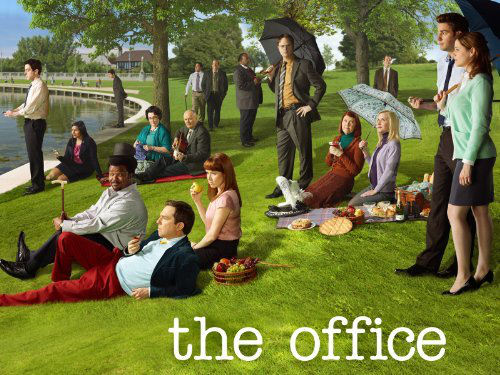

In [9]:
image = Image.open('images/office5.jpg')
image

In [10]:
width, height = image.size
min_length = min(height, width)

min_detection_size = 12
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
scales = []

# scales the image so that
# minimum size that we can detect equals to
# minimum face size that we want to detect
m = min_detection_size/min_face_size
min_length *= m

factor_count = 0
while min_length > min_detection_size:
    scales.append(m*factor**factor_count)
    min_length *= factor
    factor_count += 1

print('scales:', ['{:.2f}'.format(s) for s in scales])
print('number of different scales:', len(scales))

scales: ['0.80', '0.57', '0.40', '0.28', '0.20', '0.14', '0.10', '0.07', '0.05', '0.04']
number of different scales: 10


In [11]:
bounding_boxes = []

# run P-Net on different scales
for s in scales:
    boxes = run_first_stage(image, pnet, scale=s, threshold=thresholds[0])
    bounding_boxes.append(boxes)

# collect boxes (and offsets, and scores) from different scales
bounding_boxes = [i for i in bounding_boxes if i is not None]
bounding_boxes = np.vstack(bounding_boxes)
print('number of bounding boxes:', len(bounding_boxes))

/content/src/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile=True)
/content/src/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


number of bounding boxes: 338


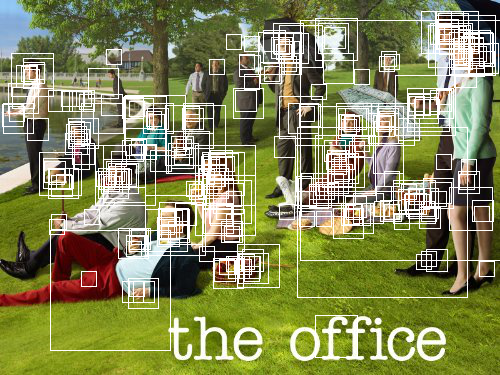

In [12]:
show_bboxes(image, bounding_boxes)

In [13]:
keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
bounding_boxes = bounding_boxes[keep]

# use offsets predicted by pnet to transform bounding boxes
bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
# shape [n_boxes, 5]

bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 338


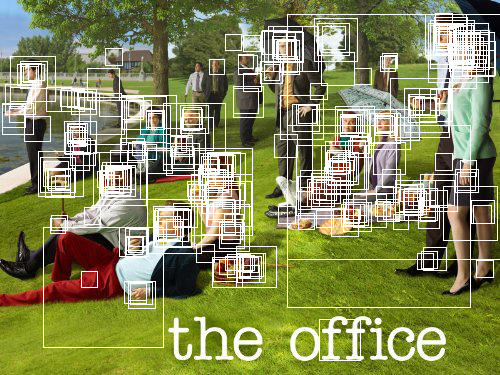

In [14]:
show_bboxes(image, bounding_boxes)

In [15]:
img_boxes = get_image_boxes(bounding_boxes, image, size=24)
img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
output = rnet(img_boxes)
offsets = output[0].data.numpy()  # shape [n_boxes, 4]
probs = output[1].data.numpy()  # shape [n_boxes, 2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/content/src/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


In [16]:
keep = np.where(probs[:, 1] > thresholds[1])[0]
bounding_boxes = bounding_boxes[keep]
bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
offsets = offsets[keep]

print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 71


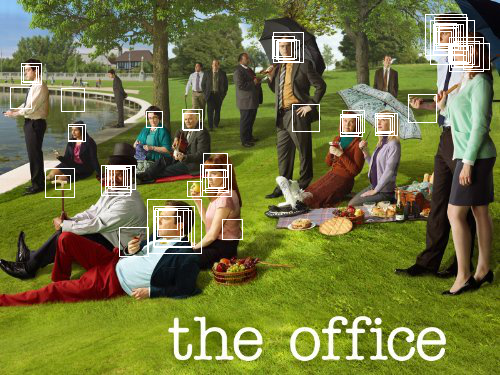

In [17]:
show_bboxes(image, bounding_boxes)

In [18]:
keep = nms(bounding_boxes, nms_thresholds[1])
bounding_boxes = bounding_boxes[keep]
bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 58


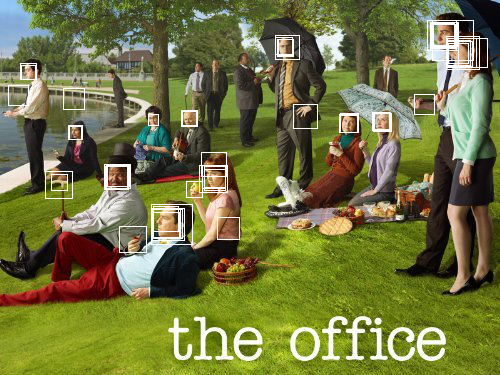

In [19]:
show_bboxes(image, bounding_boxes)

In [20]:
img_boxes = get_image_boxes(bounding_boxes, image, size=48)
img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
output = onet(img_boxes)
landmarks = output[0].data.numpy()  # shape [n_boxes, 10]
offsets = output[1].data.numpy()  # shape [n_boxes, 4]
probs = output[2].data.numpy()  # shape [n_boxes, 2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/content/src/get_nets.py:168: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


In [21]:
keep = np.where(probs[:, 1] > thresholds[2])[0]
bounding_boxes = bounding_boxes[keep]
bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
offsets = offsets[keep]
landmarks = landmarks[keep]

# compute landmark points
width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]
    
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 42


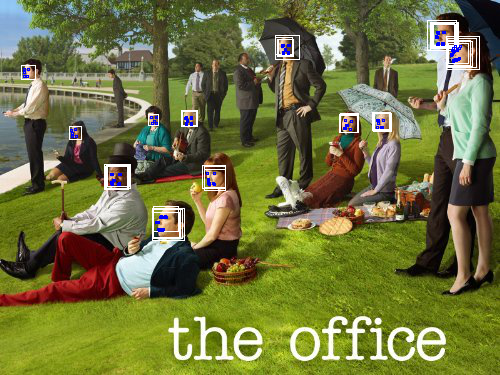

In [22]:
show_bboxes(image, bounding_boxes, landmarks)

In [23]:
bounding_boxes = calibrate_box(bounding_boxes, offsets)
keep = nms(bounding_boxes, nms_thresholds[2], mode='min')
bounding_boxes = bounding_boxes[keep]
landmarks = landmarks[keep]
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 12


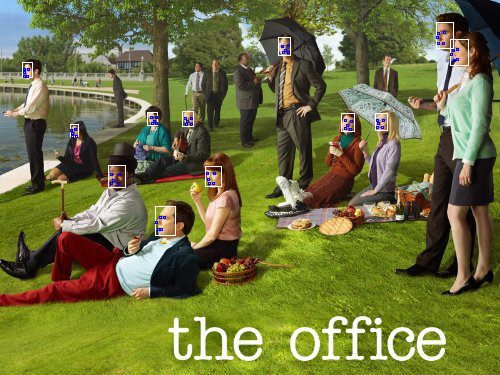

In [24]:
show_bboxes(image, bounding_boxes, landmarks)

In [25]:
len(bounding_boxes)

12